# sWeights without fitting anything

It is possible (although not recommended) to obtained sWeights without fitting anything. This approach has a large drawback, however: the variance of the sWeights is much larger than for classic sWeights, with a corresponding increase in the uncertainty of any parameters derived from the sWeighted t-distribution.

There is also a subtle issue. While it looks like we are extracting sWeights in this way that are independent of the PDF shapes (which would make error propagation easy, since sWeights could be made independent of the m-distribution), the truth is that we are choosing the shapes so that they match the data. If they don't match, then the sWeights will be biased. This makes us (the observer) part of the fit. This is analog to the flip-flopping problem, see e.g. F. James, Statistical Methods In Experimental Physics, World Scientific Publishing. Therefore, this technique actually makes it impossible to do full error propagation.

That being said, the method produces such a large variance in the sWeights that the subtle hidden correlations are probably negligible.

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import numpy as np

from sweights.testing import make_classic_toy
from sweights.util import plot_binned, make_bernstein_pdf
from sweights.experimental import Cows

We generate our usual toy experiment.

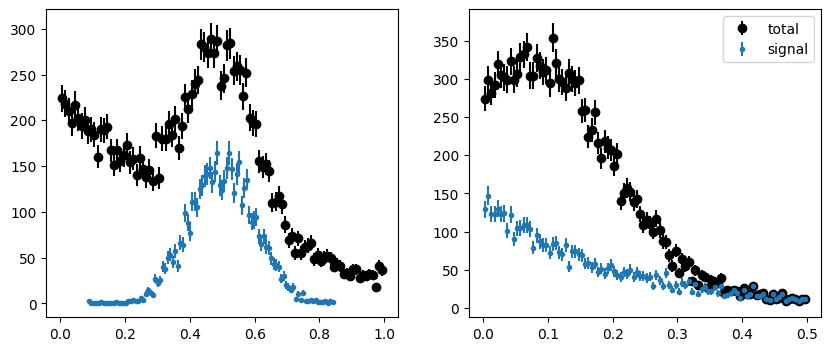

In [2]:
mrange = (0.0, 1.0)
trange = (0.0, 0.5)
tsplit = 0.2

toy = make_classic_toy(1, b=10000, mrange=mrange, trange=trange)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plot_binned(toy[0], bins=100, color="k", label="total")
plot_binned(toy[0][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.sca(ax[1])
plot_binned(toy[1], bins=100, color="k", label="total")
plot_binned(toy[1][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.legend()

To perform a fit-less computation of sWeights, we use a set of fixed signal PDF and background PDFs. As explained in our paper, one can compute weights for more than two components. We split these in two groups. The signal group consists of truncated normal distributions which peak in the middle of the distribution. These shall capture the signal. The background group consists of Bernstein basis polynomials, which shall capture the smooth background. Computing sWeights will work as long as the signal pdfs cannot be expressed as a linear combination of the background pdfs or vice versa. If they are, then you will get an error message when you construct COWs.

In [3]:
class truncnorm:
    def __init__(self, a, b, mu, sigma):
        d = norm(mu, sigma)
        self.d = d
        self.norm = d.cdf(b) - d.cdf(a)

    def __call__(self, x):
        return self.d.pdf(x) / self.norm


def make_norm_pdf(a, b, mu, sigma):
    mu, sigma = np.broadcast_arrays(mu, sigma)
    return [truncnorm(a, b, mui, sigmai) for (mui, sigmai) in zip(mu, sigma)]

We use three background pdfs and four signal pdfs, this is how they look like. Note that the true background is exponential, but we pretend here that we don't know this.

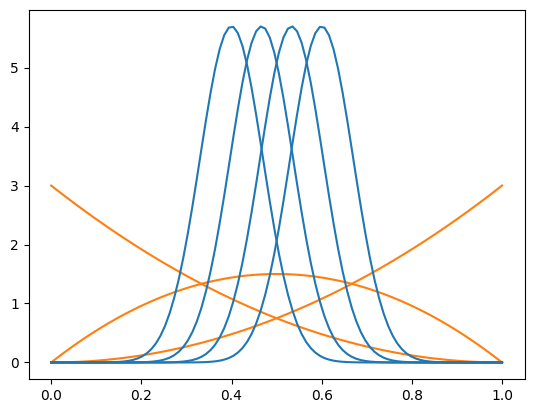

In [4]:
bpdfs = make_bernstein_pdf(2, *mrange)
spdfs = make_norm_pdf(*mrange, np.linspace(0.4, 0.6, 4), 0.07)

x = np.linspace(*mrange, 100)
for bpdf in bpdfs:
    plt.plot(x, bpdf(x), color="C1")
for spdf in spdfs:
    plt.plot(x, spdf(x), color="C0")

Now we compute the COWs. Note that we compute them without passing in the sample, so the weights are apparently independent of the sample. Actually they are not, because we chose them so that they are able to describe the signal and background, respectively. We check that explicitly by fitting them. Note that `Cows` will do this fit automatically if you provide the sample, because it reduces the variance of the weights. But we are not doing this here, because we want to compute the weights without explicitly using the sample.

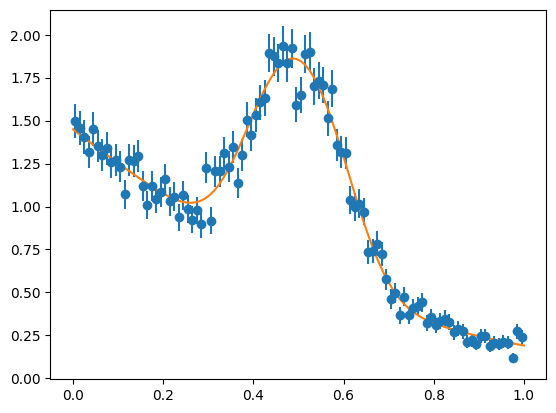

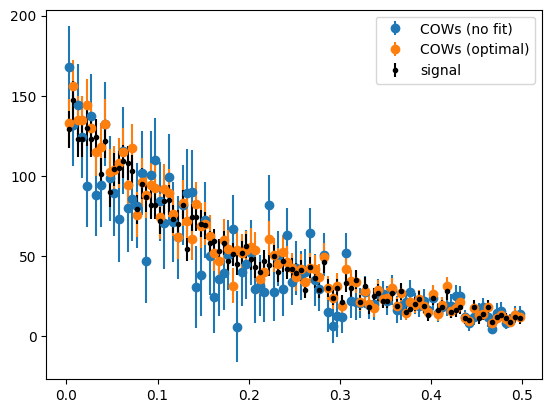

In [5]:
cows = Cows(None, spdfs, bpdfs, range=mrange)

# let's check whether these pdfs are able to describe the observed density
def model(x, par):
    return sum(par), sum(p * pdf(x) for (p, pdf) in zip(par, cows.pdfs))


m = Minuit(ExtendedUnbinnedNLL(toy[0], model), np.ones(len(cows.pdfs)))
m.migrad()

plt.figure()
plot_binned(toy[0], density=True)
x = np.linspace(*mrange, 100)
yn, y = model(x, m.values)
plt.plot(x, y / yn)


# for reference, let's compute optimal COWs as well
def norm_par(x, mu, sigma):
    d = norm(mu, sigma)
    return d.pdf(x) / np.diff(d.cdf(mrange))


def expon_par(x, slope):
    d = expon(0, slope)
    return d.pdf(x) / np.diff(d.cdf(mrange))


cows2 = Cows(
    toy[0],
    norm_par,
    expon_par,
    bounds={
        norm_par: {"mu": (0, 1), "sigma": (0, np.inf)},
        expon_par: {"slope": (0, np.inf)},
    },
)

# now we plot the true signal in the t-variable and the weighted estimate
plt.figure()
plot_binned(toy[1], weights=cows(toy[0]), label="COWs (no fit)")
plot_binned(toy[1], weights=cows2(toy[0]), label="COWs (optimal)")
plot_binned(toy[1][toy[2]], marker=".", color="k", label="signal")
plt.legend();

The optimal COWs have much smaller variance than the COWs computed without fitting anything. The no-fit COWs are always much worse, because the variance of the weights increases a lot with every component that has to be separated. This becomes clear when we look at the weight functions.

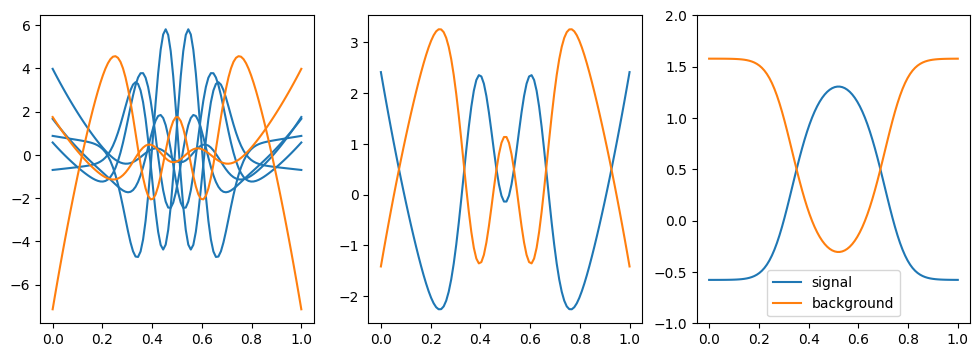

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plt.sca(ax[0])
for i, ci in enumerate(cows):
    plt.plot(x, ci(x), color="C0" if i <= cows._sig else "C1")
plt.sca(ax[1])
plt.plot(x, cows(x), color="C0", label="signal")
plt.plot(
    x,
    sum(cows[i](x) for i in range(cows._sig, len(cows))),
    color="C1",
    label="background",
)
plt.sca(ax[2])
plt.plot(x, cows2[0](x), color="C0", label="signal")
plt.plot(x, cows2[1](x), color="C1", label="background")
plt.ylim(-1, 2)
plt.legend()

Shown on the left are the weight functions for each component. Shown in the middle are the sums of the signal and the background components, respectively. COWs are additive, therefore the sum of all signal components produces the signal COW. Shown on the right are the optimal COWs.

We can see that the optimal signal COW shows low variation and peaks where the signal is the strongest. The no-fit signal COW shows several oscillations and does peak where the most of the signal is.

## Robustness

Even if the component PDFs for signal are chosen poorly, the signal weights will produce an unbiased signal density in the t-variable as long as the true background can be approximated by a linear combination of the background PDFs. This is a proven property you can find in an appendix of our COWs paper. The amplitude of the signal density will be off, but the shape will be unbiased. Here is a demonstration.

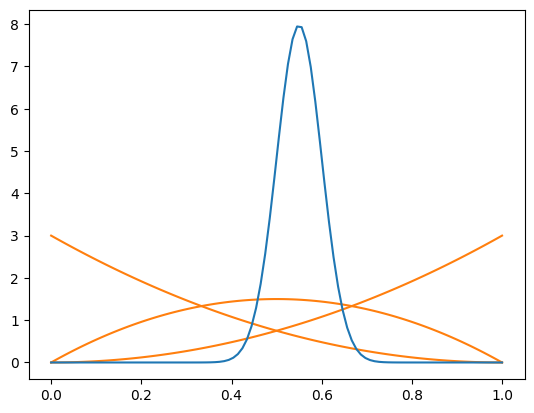

In [7]:
bpdfs = make_bernstein_pdf(2, *mrange)
spdfs = make_norm_pdf(*mrange, [0.55], 0.05)

x = np.linspace(*mrange, 100)
for bpdf in bpdfs:
    plt.plot(x, bpdf(x), color="C1")
for spdf in spdfs:
    plt.plot(x, spdf(x), color="C0")

We can see that this approximation of the signal is not adequate by fitting it to the sample distribution, which is clearly a bad fit. Nevertheless, the COW-weighted signal in the t-variable looks good, if we normalize the weighted densities.

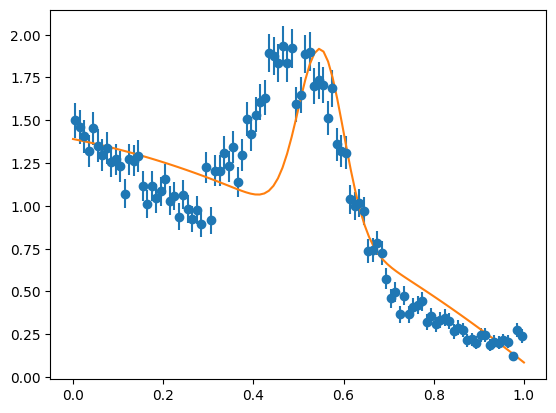

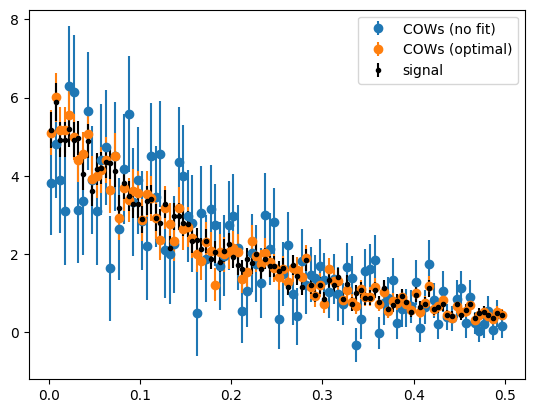

In [8]:
cows = Cows(None, spdfs, bpdfs, range=mrange)

# let's check whether these pdfs are able to describe the observed density
def model(x, par):
    return sum(par), sum(p * pdf(x) for (p, pdf) in zip(par, cows.pdfs))


m = Minuit(ExtendedUnbinnedNLL(toy[0], model), np.ones(len(cows.pdfs)))
m.migrad()

plt.figure()
plot_binned(toy[0], density=True)
x = np.linspace(*mrange, 100)
yn, y = model(x, m.values)
plt.plot(x, y / yn)

# now we plot the true signal in the t-variable and the weighted estimate
plt.figure()
plot_binned(toy[1], weights=cows(toy[0]), density=True, label="COWs (no fit)")
plot_binned(toy[1], weights=cows2(toy[0]), density=True, label="COWs (optimal)")
plot_binned(toy[1][toy[2]], density=True,  marker=".", color="k", label="signal")
plt.legend();